In [1]:
# known import statements
from bs4 import BeautifulSoup
import os
import pandas as pd

# let's import sqlite3 module
import sqlite3

### Warmup 1: Explore this HTML table of volunteer hours

<table>
    <tr> 
        <th>Name</th>
        <th>Week 1</th>
        <th>Week 2</th
        ><th>Week 3</th> 
    </tr>
    <tr> 
        <td>Therese</td>
        <td>13</td>
        <td>4</td>
        <td>5</td> 
    </tr>
    <tr> 
        <td>Carl</td>
        <td>5</td>
        <td>7</td>
        <td>8</td> 
    </tr>
    <tr> 
        <td>Marie</td>
        <td>2</td>
        <td>9</td>
        <td>11</td> 
    </tr>
</table>

### Warmup 2a: Parse "hours.html" using BeautifulSoup

#### Step 1: Read contents from "hours.html" file

In [2]:
f = open("hours.html")
data = f.read()
f.close()

#### Step 2: Create a BeautifulSoup object instance

In [3]:
bs_obj = BeautifulSoup(data, 'html.parser')

#### Step 3: Parse the table

In [4]:
table = bs_obj.find("table") # works only if there is 1 table

# Q: what method do you need if the HTML has more than 1 table? 
# A: find_all method and then extract the appropriate table using indexing

#### Step 4: Parse the header
- Bonus: Use list comprehension 

In [5]:
th_elements = table.find_all("th")
header = [th.get_text() for th in th_elements]
header

['Name', 'Week 1', 'Week 2', 'Week 3']

#### Step 5: Parse the data rows and store data into a list of dict
- Remember that you need to skip over the first tr (which contains the header)

In [6]:
# Find all tr elements
tr_elements = bs_obj.find_all("tr")

# Skip first tr row (header row)
tr_elements = tr_elements[1:]

# Initialize empty list
work_hours = []

# Iterate through the tr elements
for tr in tr_elements:
    # Find all "td" elements in this row
    td_elements = tr.find_all("td")
    
    # Create row dictionary
    row_dict = {} # Key: column name (header); Value: cell's value
    
    # Iterate over indices of td elements
    for idx in range(len(td_elements)): # Assumes that td_elements and header have same length
        # Extract the td text
        td_val = td_elements[idx].get_text()

        # Make appropriate type conversions
        # Use header instead of hardcoing index
        if header[idx] in ["Week 1", "Week 2", "Week 3"]:
            td_val = int(td_val)
            
        # Insert key-value pairs        
        row_dict[header[idx]] = td_val
        
    # Append row dictionary into list
    work_hours.append(row_dict)
    
work_hours

[{'Name': 'Therese', 'Week 1': 13, 'Week 2': 4, 'Week 3': 5},
 {'Name': 'Carl', 'Week 1': 5, 'Week 2': 7, 'Week 3': 8},
 {'Name': 'Marie', 'Week 1': 2, 'Week 2': 9, 'Week 3': 11}]

### Warmup 3: Use appropriate os module to assert that bus.db in this directory

In [7]:
assert os.path.exists("bus.db")

## April 20: DataBase1

### Learning Objectives:

- Explain how a database is different from a CSV file or a JSON file
- Use SQLite to connect to a database and pandas to query the database
- Write basic queries on a database using SELECT, FROM, WHERE, ORDER BY, and LIMIT

We will get started with slides.

In [8]:
# Get the Bus data from 'bus.db'
db_name = "bus.db"
assert os.path.exists(db_name)
# Why do we have to assert that database exists?
# If the database file does not exist, connect function creates a brand new one!

# open a connection object to our database file
conn = sqlite3.connect(db_name)

# Important note: we need to close 'conn' when we are done, at the end of the notebook file
type(conn)

sqlite3.Connection

### Pandas has a .read_sql function  `pd.read_sql(query, connection)`
- Allows us to process an SQL `query` on a SQL `connection`
- stores the result in a Pandas DataFrame
- First SQL query to always run on a database:
```
select * from sqlite_master
```

In [10]:
# This SQL query helps us know the table names, we don't use the other info 
df = pd.read_sql("select * from sqlite_master", conn)
df

# Key observation: there are two tables: boarding and routes

type               name  tbl_name  rootpage  \
0  table           boarding  boarding         2   
1  index  ix_boarding_index  boarding         3   
2  table             routes    routes        55   
3  index    ix_routes_index    routes        57   

                                                 sql  
0  CREATE TABLE "boarding" (\n"index" INTEGER,\n ...  
1  CREATE INDEX "ix_boarding_index"ON "boarding" ...  
2  CREATE TABLE "routes" (\n"index" INTEGER,\n  "...  
3  CREATE INDEX "ix_routes_index"ON "routes" ("in...

### Databases are more structured than CSV and JSON files:
- all data contained inside one or more tables
- all tables must be named, all columns must be named 
- all values in a column must be the same type

In [10]:
# The SQL queries in sql column of the returned DataFrame show
# how database was set up (not part of CS220).

# Let's focus on the table names and column names
for command in df["sql"]:
    print(command)
    
# Key observation: SQL has its own types (pandas takes care of the type conversions) 
# and the types are strictly enforced

CREATE TABLE "boarding" (
"index" INTEGER,
  "StopID" INTEGER,
  "Route" INTEGER,
  "Lat" REAL,
  "Lon" REAL,
  "DailyBoardings" REAL
)
CREATE INDEX "ix_boarding_index"ON "boarding" ("index")
CREATE TABLE "routes" (
"index" INTEGER,
  "OBJECTID" INTEGER,
  "trips_routes_route_id" INTEGER,
  "route_short_name" INTEGER,
  "route_url" TEXT,
  "ShapeSTLength" REAL
)
CREATE INDEX "ix_routes_index"ON "routes" ("index")


### Most basic SQL query
```
SELECT <Column(s)> 
FROM <Table name>
```
- `SELECT` and `FROM` are mandatory clauses in a SQL query
- Can use * to mean "all columns"

In [11]:
# pandas continues to be an awesome tool
# pandas allows us to write a SQL query and create a DataFrame
pd.read_sql("select * from routes", conn)

index  OBJECTID  trips_routes_route_id  route_short_name  \
0       0        63                   8052                 1   
1       1        64                   8053                 2   
2       2        65                   8054                 3   
3       3        66                   8055                 4   
4       4        67                   8056                 5   
..    ...       ...                    ...               ...   
57     57       120                   8109                78   
58     58       121                   8110                80   
59     59       122                   8111                81   
60     60       123                   8112                82   
61     61       124                   8113                84   

                                            route_url  ShapeSTLength  
0   http://www.cityofmadison.com/Metro/schedules/R...   32379.426524  
1   http://www.cityofmadison.com/Metro/schedules/R...   96906.965571  
2   http://www.cityofmadison.com/Metro/schedules/R...   76436.645644  
3   http://www.cityofmadison.com/Metro/schedules/R...   64774.133485  
4   http://www.cityofmadison.com/Metro/schedules/R...   61216.722662  
..                                                ...            ...  
57  http://www.cityofmadison.com/Metro/schedules/R...   95826.277218  
58  http://www.cityofmadison.com/Metro/schedules/R...   31831.761009  
59  http://www.cityofmadison.com/Metro/schedules/R...   26536.800591  
60  http://www.cityofmadison.com/Metro/schedules/R...   23287.980173  
61  http://www.cityofmadison.com/Metro/schedules/R...   20681.958334  

[62 rows x 6 columns]

In [12]:
# TODO: Now write a SQL query for displaying all columns from boarding table
pd.read_sql("select * from boarding", conn)

index  StopID  Route        Lat        Lon  DailyBoardings
0         0    1163     27  43.073655 -89.385427            1.03
1         1    1163     47  43.073655 -89.385427            0.11
2         2    1163     75  43.073655 -89.385427            0.34
3         3    1164      6  43.106465 -89.340021           10.59
4         4    1167      3  43.077867 -89.369993            3.11
...     ...     ...    ...        ...        ...             ...
3967   3967    6533     67  43.057329 -89.510756           16.88
3968   3968    6539     15  43.064361 -89.517233           15.53
3969   3969    6541      3  43.049934 -89.478167            2.56
3970   3970    6543     70  43.093289 -89.501726            0.11
3971   3971    6543     71  43.093289 -89.501726            6.73

[3972 rows x 6 columns]

### Optional SQL clauses
- WHERE: filters rows based on a column condition
- ORDER BY: sorting (`ASC` or `DESC` after the column name specify the ordering)
- LIMIT: simplistic filter (similar to slicing / head/tail functions in pandas DataFrames)

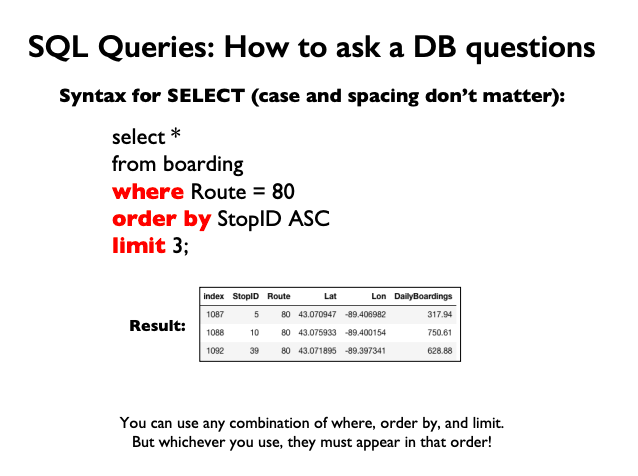

### What are all the details of route 80 bus stops?

In [13]:
query = """
select *
from boarding
where Route = 80
"""
pd.read_sql(query, conn)

index  StopID  Route        Lat        Lon  DailyBoardings
0     732    2007     80  43.076436 -89.424388           72.82
1     733    2014     80  43.089239 -89.433760           99.50
2     735    2018     80  43.086293 -89.435043            6.23
3     737    2023     80  43.078800 -89.429795          100.05
4     738    2026     80  43.086248 -89.436661           18.45
5     739    2027     80  43.080259 -89.428067            4.34
6     740    2034     80  43.086445 -89.433772          120.73
7     741    2039     80  43.089158 -89.438057           86.27
8     742    2041     80  43.084252 -89.433487            1.56
9     743    2048     80  43.084386 -89.433784           83.38
10    744    2050     80  43.080886 -89.428351            5.00
11    745    2053     80  43.077045 -89.424906            3.78
12    746    2054     80  43.086668 -89.441612          177.54
13    747    2061     80  43.089784 -89.437007           57.81
14    749    2071     80  43.090501 -89.435587           32.02
15    750    2076     80  43.079006 -89.429203           41.69
16    751    2082     80  43.086328 -89.438587          270.14
17    755    2088     80  43.076759 -89.425770            4.56
18    760    2091     80  43.076973 -89.428499          248.24
19    790    2125     80  43.077349 -89.428844           61.81
20    811    2145     80  43.076319 -89.412882          321.06
21    865    2195     80  43.076347 -89.416104          984.51
22    906    2240     80  43.078988 -89.426659            0.67
23    923    2267     80  43.076382 -89.419943          455.02
24    968    2349     80  43.078388 -89.430227          561.96
25   1087       5     80  43.070947 -89.406982          317.94
26   1088      10     80  43.075933 -89.400154          750.61
27   1092      39     80  43.071895 -89.397341          628.88
28   1095      49     80  43.075529 -89.397191          690.92
29   1099      52     80  43.076131 -89.405660          243.91
30   1104      60     80  43.075996 -89.403660          160.42
31   1106      61     80  43.070893 -89.403698          154.41
32   1109      73     80  43.070820 -89.398650          412.10
33   1110      77     80  43.070857 -89.401119          143.07
34   1245     184     80  43.075254 -89.410413          237.79
35   1341     298     80  43.075290 -89.412894           94.05
36   1351     336     80  43.072028 -89.409136          528.28
37   1412     438     80  43.074985 -89.406401          451.01
38   1476     488     80  43.075200 -89.407339          607.87
39   1519     532     80  43.075254 -89.412549          137.52
40   1574     573     80  43.075030 -89.410339          159.97
41   1664     706     80  43.073767 -89.406352           74.37
42   1715     765     80  43.073076 -89.397291          317.61
43   3002    2442     80  43.076588 -89.419301           91.27
44   3256    2881     80  43.084225 -89.429092           12.78
45   3329    2978     80  43.076561 -89.416289           88.71
46   3341    2996     80  43.076534 -89.413067           89.16

#### Sort the route 80 rows based on ascending order of DailyBoardings column.

In [14]:
query = """
select *
from boarding
where Route = 80
order by DailyBoardings ASC
"""
pd.read_sql(query, conn)

index  StopID  Route        Lat        Lon  DailyBoardings
0     906    2240     80  43.078988 -89.426659            0.67
1     742    2041     80  43.084252 -89.433487            1.56
2     745    2053     80  43.077045 -89.424906            3.78
3     739    2027     80  43.080259 -89.428067            4.34
4     755    2088     80  43.076759 -89.425770            4.56
5     744    2050     80  43.080886 -89.428351            5.00
6     735    2018     80  43.086293 -89.435043            6.23
7    3256    2881     80  43.084225 -89.429092           12.78
8     738    2026     80  43.086248 -89.436661           18.45
9     749    2071     80  43.090501 -89.435587           32.02
10    750    2076     80  43.079006 -89.429203           41.69
11    747    2061     80  43.089784 -89.437007           57.81
12    790    2125     80  43.077349 -89.428844           61.81
13    732    2007     80  43.076436 -89.424388           72.82
14   1664     706     80  43.073767 -89.406352           74.37
15    743    2048     80  43.084386 -89.433784           83.38
16    741    2039     80  43.089158 -89.438057           86.27
17   3329    2978     80  43.076561 -89.416289           88.71
18   3341    2996     80  43.076534 -89.413067           89.16
19   3002    2442     80  43.076588 -89.419301           91.27
20   1341     298     80  43.075290 -89.412894           94.05
21    733    2014     80  43.089239 -89.433760           99.50
22    737    2023     80  43.078800 -89.429795          100.05
23    740    2034     80  43.086445 -89.433772          120.73
24   1519     532     80  43.075254 -89.412549          137.52
25   1110      77     80  43.070857 -89.401119          143.07
26   1106      61     80  43.070893 -89.403698          154.41
27   1574     573     80  43.075030 -89.410339          159.97
28   1104      60     80  43.075996 -89.403660          160.42
29    746    2054     80  43.086668 -89.441612          177.54
30   1245     184     80  43.075254 -89.410413          237.79
31   1099      52     80  43.076131 -89.405660          243.91
32    760    2091     80  43.076973 -89.428499          248.24
33    751    2082     80  43.086328 -89.438587          270.14
34   1715     765     80  43.073076 -89.397291          317.61
35   1087       5     80  43.070947 -89.406982          317.94
36    811    2145     80  43.076319 -89.412882          321.06
37   1109      73     80  43.070820 -89.398650          412.10
38   1412     438     80  43.074985 -89.406401          451.01
39    923    2267     80  43.076382 -89.419943          455.02
40   1351     336     80  43.072028 -89.409136          528.28
41    968    2349     80  43.078388 -89.430227          561.96
42   1476     488     80  43.075200 -89.407339          607.87
43   1092      39     80  43.071895 -89.397341          628.88
44   1095      49     80  43.075529 -89.397191          690.92
45   1088      10     80  43.075933 -89.400154          750.61
46    865    2195     80  43.076347 -89.416104          984.51

#### Sort the route 80 rows based on descending order of DailyBoardings column.

In [15]:
query = """
select *
from boarding
where Route = 80
order by DailyBoardings DESC
"""
pd.read_sql(query, conn)

index  StopID  Route        Lat        Lon  DailyBoardings
0     865    2195     80  43.076347 -89.416104          984.51
1    1088      10     80  43.075933 -89.400154          750.61
2    1095      49     80  43.075529 -89.397191          690.92
3    1092      39     80  43.071895 -89.397341          628.88
4    1476     488     80  43.075200 -89.407339          607.87
5     968    2349     80  43.078388 -89.430227          561.96
6    1351     336     80  43.072028 -89.409136          528.28
7     923    2267     80  43.076382 -89.419943          455.02
8    1412     438     80  43.074985 -89.406401          451.01
9    1109      73     80  43.070820 -89.398650          412.10
10    811    2145     80  43.076319 -89.412882          321.06
11   1087       5     80  43.070947 -89.406982          317.94
12   1715     765     80  43.073076 -89.397291          317.61
13    751    2082     80  43.086328 -89.438587          270.14
14    760    2091     80  43.076973 -89.428499          248.24
15   1099      52     80  43.076131 -89.405660          243.91
16   1245     184     80  43.075254 -89.410413          237.79
17    746    2054     80  43.086668 -89.441612          177.54
18   1104      60     80  43.075996 -89.403660          160.42
19   1574     573     80  43.075030 -89.410339          159.97
20   1106      61     80  43.070893 -89.403698          154.41
21   1110      77     80  43.070857 -89.401119          143.07
22   1519     532     80  43.075254 -89.412549          137.52
23    740    2034     80  43.086445 -89.433772          120.73
24    737    2023     80  43.078800 -89.429795          100.05
25    733    2014     80  43.089239 -89.433760           99.50
26   1341     298     80  43.075290 -89.412894           94.05
27   3002    2442     80  43.076588 -89.419301           91.27
28   3341    2996     80  43.076534 -89.413067           89.16
29   3329    2978     80  43.076561 -89.416289           88.71
30    741    2039     80  43.089158 -89.438057           86.27
31    743    2048     80  43.084386 -89.433784           83.38
32   1664     706     80  43.073767 -89.406352           74.37
33    732    2007     80  43.076436 -89.424388           72.82
34    790    2125     80  43.077349 -89.428844           61.81
35    747    2061     80  43.089784 -89.437007           57.81
36    750    2076     80  43.079006 -89.429203           41.69
37    749    2071     80  43.090501 -89.435587           32.02
38    738    2026     80  43.086248 -89.436661           18.45
39   3256    2881     80  43.084225 -89.429092           12.78
40    735    2018     80  43.086293 -89.435043            6.23
41    744    2050     80  43.080886 -89.428351            5.00
42    755    2088     80  43.076759 -89.425770            4.56
43    739    2027     80  43.080259 -89.428067            4.34
44    745    2053     80  43.077045 -89.424906            3.78
45    742    2041     80  43.084252 -89.433487            1.56
46    906    2240     80  43.078988 -89.426659            0.67

### Which 10 bus stops have the lowest DailyBoardings and for what bus?

In [16]:
query = """
SELECT Route, DailyBoardings  
FROM boarding  
ORDER BY DailyBoardings DESC
LIMIT 10
"""
pd.read_sql(query, conn)

Route  DailyBoardings
0     80          984.51
1     80          750.61
2     80          690.92
3     80          628.88
4     80          607.87
5     80          561.96
6     80          528.28
7     80          455.02
8     80          451.01
9     80          412.10

### What are the top 3 stops (based on DailyBoardings) of route 3?

In [17]:
query = """
SELECT StopID, DailyBoardings, Route  
FROM boarding  
WHERE route = 3 
ORDER BY DailyBoardings DESC
LIMIT 3
"""
pd.read_sql(query, conn)

StopID  DailyBoardings  Route
0     581          109.95      3
1    7100          109.51      3
2     670          103.17      3

### Go West - which bus should I take to go as far west as possible?
- Smallest Longitude

In [18]:
qry = """
SELECT *
FROM boarding
ORDER BY Lon ASC
LIMIT 1
"""
pd.read_sql(qry, conn)

index  StopID  Route        Lat        Lon  DailyBoardings
0   3489    4400     55  42.995476 -89.564243           59.31

In [19]:
# TODO: make a tuple out of this lat-long and enter that tuple into Google Maps
# TODO: Where is this location?

### How many people get on a bus in Madison every day?
- we are interested in boarding table to answer this question

In [20]:
#Answer using pandas
qry = """
SELECT DailyBoardings 
FROM boarding
"""
df = pd.read_sql(qry, conn)
bus_riders = df["DailyBoardings"]
bus_riders.sum()

55987.18

In [21]:
# Next lecture, we'll learn all about SQL summarization

#Using SQL summarization
qry = """
SELECT SUM(DailyBoardings)
FROM boarding
"""
pd.read_sql(qry, conn)

SUM(DailyBoardings)
0             55987.18

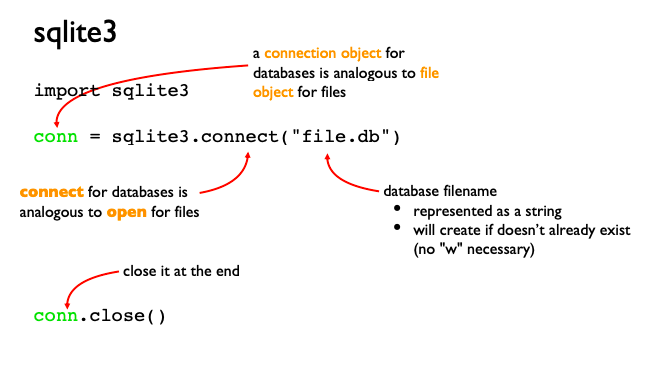

In [22]:
# don't forget to close your connection!
conn.close()